In [1]:
import sent2vec
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
"""
https://github.com/ncbi-nlp/BioSentVec/tree/master
https://github.com/epfml/sent2vec 
#### I had to clone this repo, build it, and run the notebook from inside here to get Sent2vecModel to work
"""

model_path = "/Users/AZ01DN/Downloads/"
model = sent2vec.Sent2vecModel()
model.load_model("/Users/AZ01DN/Downloads/BioSentVec_PubMed_MIMICIII-bigram_d700.bin")

In [3]:
df = pd.read_csv("dummy.tsv", sep="\t")
print(df.head())

  Number                                        ChatGPT 3.5  \
0     Q1  Basal cell carcinoma (BCC) treatment options v...   
1     Q2  The treatment option for basal cell carcinoma ...   
2     Q3  Topical medications are generally not the firs...   
3     Q4  Topical treatments for basal cell carcinoma (B...   
4     Q5  When using topical medications for basal cell ...   

                                              Gemini  \
0  Here's a breakdown of the various treatment op...   
1  The treatment option for basal cell carcinoma ...   
2  Here's a breakdown of topical treatments for b...   
3  Absolutely, there are risks associated with to...   
4  Yes, there are potential drug interactions and...   

                                            Co-Pilot  \
0  Basal cell carcinoma (BCC) is a common type of...   
1  There are several treatment options for basal ...   
2  Topical treatments for basal cell carcinoma ty...   
3  Yes, there are some risks associated with topi...   
4  Y

In [4]:
stop_words = set(stopwords.words('english'))
def cleaner(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]
    #print(' '.join(tokens))
    return ' '.join(tokens) 

In [5]:
print("----- Words removed during cleaning ----")
print(stop_words)
print("--------------------------------------------------------")
print(f"example:")
print(f"BEFORE:")
print(df["ChatGPT 3.5"][0])
print("~*~*~*~*~*~*~")
print(f"AFTER:")
print(cleaner(df["ChatGPT 3.5"][0]))


----- Words removed during cleaning ----
{'y', 'why', 'against', 'him', 'i', 'are', 'the', 'of', 'ourselves', 'from', 'wasn', 'both', 'haven', 'over', "won't", 'don', 'does', 'your', 'such', 'it', 'now', 'doesn', 'was', 'yourself', 'itself', 'each', 'they', 'under', 'me', 'aren', "shan't", 'by', 'more', 'd', 'themselves', "you'll", 're', 'should', 'ain', 'needn', "hasn't", 'myself', 'do', 'couldn', 'our', "she's", 'which', 'there', 'during', 'its', 'mightn', "needn't", 'mustn', 'at', "shouldn't", 'up', 'didn', "you're", "haven't", "wasn't", 'few', 'other', 'too', 'am', 'for', 'very', 'just', 'above', 'his', 'did', 'is', 'herself', 'because', 'while', 'ours', 'those', 'this', 'than', 's', 'again', 'being', 'to', 'weren', 'below', 'm', 'but', 'doing', "you've", 'he', 't', 'once', 'shan', 'or', 'same', "mightn't", 'isn', 'whom', "don't", 'my', 'between', 'ma', 'here', 'hers', 'll', 'with', "isn't", "weren't", 'you', 'an', 'himself', 'into', 'shouldn', 'hasn', 'having', "should've", 'can',

In [6]:
cs_dict = {"index": [], "cos": [], "pair": []} #cosine similarity dict

def question_wise_comparison(x, y):
    """
    Input
    x: str (column name)
    y: str (column name)

    Output:
    Appends to the global cs_dict, for observing the distributions of similarities 
    """
    column_x = list(df[x])
    column_y = list(df[y])
    assert len(column_x) == len(column_y)
    i = 1
    for t1, t2 in zip(column_x, column_y):
        c1 = cleaner(t1)
        c2 = cleaner(t2)
        v1 = model.embed_sentence(c1)
        v2 = model.embed_sentence(c2)
        cosine_sim = 1 - distance.cosine(v1[0], v2[0])
        #print('cosine similarity:', cosine_sim)
        #print("====="*5)
        cs_dict["cos"].append(cosine_sim)
        cs_dict["pair"].append(f"{x} & {y}")
        cs_dict["index"].append(i)
        i += 1
        

####### GPT3 vs the rest (3)
print("ChatGPT 3.5 and Gemini")
question_wise_comparison("ChatGPT 3.5", "Gemini")
print("--------------------------------------------------------")
print("ChatGPT 3.5 and Co-Pilot")
question_wise_comparison("ChatGPT 3.5", "Co-Pilot")
print("--------------------------------------------------------")
print("ChatGPT 3.5 and ChatGPT 4.0")
question_wise_comparison("ChatGPT 3.5", "ChatGPT 4.0")
print("--------------------------------------------------------")

######## Gemini vs (the rest - GPT3) = 2
print("Gemini and Co-Pilot")
question_wise_comparison("Gemini", "Co-Pilot")
print("--------------------------------------------------------")
print("Gemini and ChatGPT 4.0")
question_wise_comparison("Gemini", "ChatGPT 4.0")
print("--------------------------------------------------------")

####### Co-Pilot vs (the rest - GPT3 - Gemini ) = 1
print("Co-Pilot and GPT 4.0")
question_wise_comparison("Co-Pilot", "ChatGPT 4.0")
print("--------------------------------------------------------")

####### GPT4 vs (the rest - GPT3 - Gemini - CoPilot) = 0

ChatGPT 3.5 and Gemini
--------------------------------------------------------
ChatGPT 3.5 and Co-Pilot
--------------------------------------------------------
ChatGPT 3.5 and ChatGPT 4.0
--------------------------------------------------------
Gemini and Co-Pilot
--------------------------------------------------------
Gemini and ChatGPT 4.0
--------------------------------------------------------
Co-Pilot and GPT 4.0
--------------------------------------------------------


<Axes: xlabel='index', ylabel='cos'>

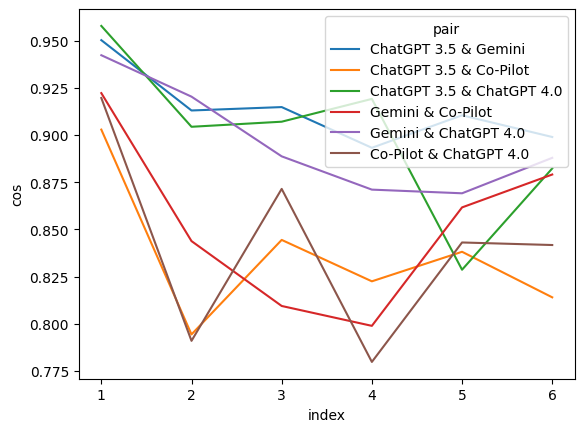

In [7]:
sns.lineplot(data=cs_dict, x="index", y="cos", hue="pair") # Exception question index doesn't make sense as time-like x-axis 

<Axes: xlabel='cos', ylabel='Count'>

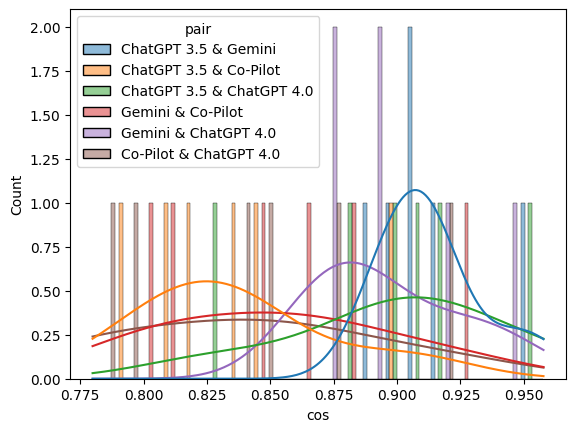

In [8]:
sns.histplot(data=cs_dict, x="cos", bins=20, hue="pair", multiple="dodge", kde=True)

<Axes: xlabel='cos', ylabel='Density'>

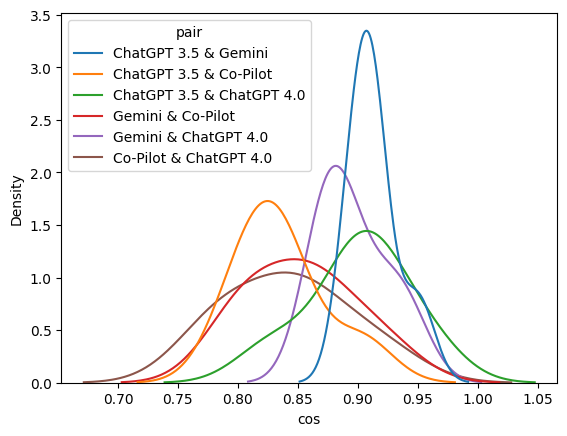

In [9]:
sns.kdeplot(data=cs_dict, x="cos", hue="pair")

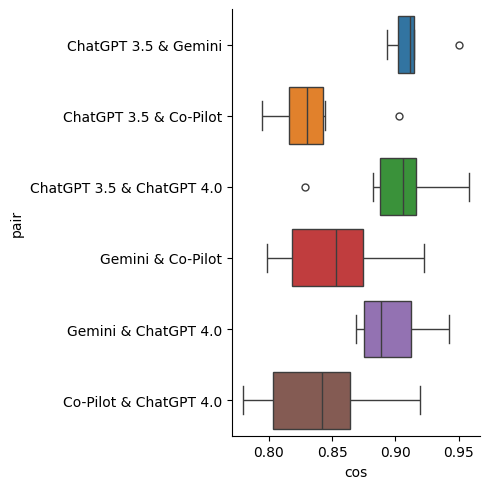

In [10]:
sns.catplot(data=cs_dict, x="cos", y="pair", kind="box", hue="pair")

<Axes: xlabel='cos', ylabel='pair'>

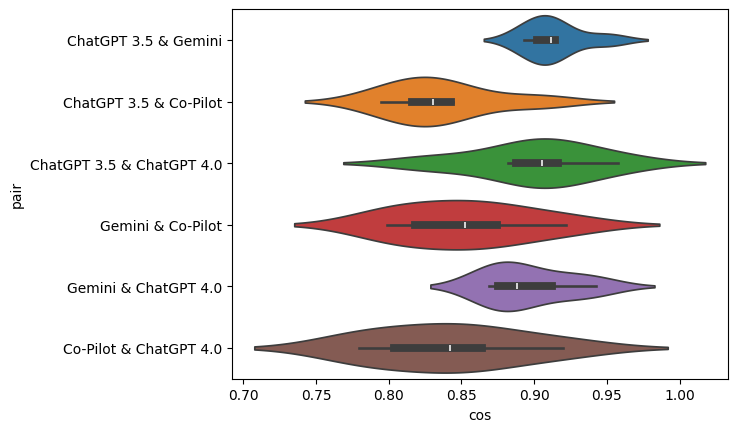

In [11]:
sns.violinplot(data=cs_dict, x="cos", y="pair", hue="pair")

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")                                                                        
#bert_model = AutoModel.from_pretrained("medicalai/ClinicalBERT") 

In [ ]:
def bert_similarity(x, y):
    #https://huggingface.co/medicalai/ClinicalBERT
    
    column_x = list(df[x])
    column_y = list(df[y])
    assert len(column_x) == len(column_y)
    for t1, t2 in zip(column_x, column_y):
        encoded_t1 = tokenizer(t1[:511], return_tensors="pt").to("cpu")
        encoded_t2 = tokenizer(t2[:511], return_tensors="pt").to("cpu")

        #TODO padding 512
        output1 = bert_model(**encoded_t1)
        output2 = bert_model(**encoded_t2)
        v1 = output1[0].detach().numpy()[0]
        v2 = output2[0].detach().numpy()[0]
        #cs = cosine_similarity(v1, v2)
        #print(cs)
        print(1 - distance.cosine(v1[0], v2[0]))
        
#bert_similarity("ChatGPT", "Gemini")
#print("--------------------------------------------------------")
#bert_similarity("ChatGPT", "Co-Pilot")

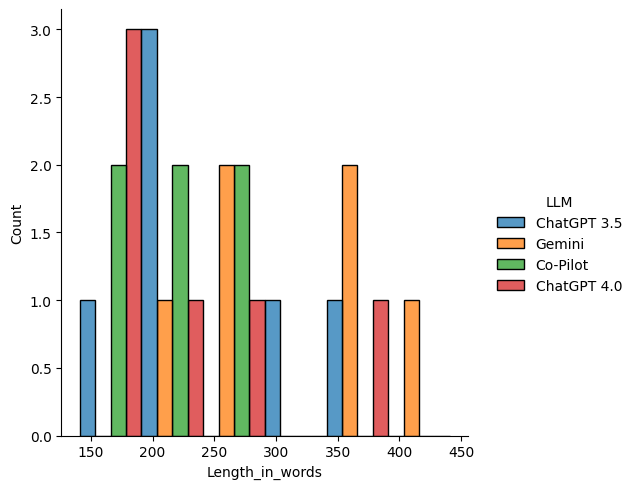

In [12]:
def plot_lengths(df):
    #https://seaborn.pydata.org/tutorial/distributions.html 
    gpt_lengths =  [len(x.split(" ")) for x in list(df["ChatGPT 3.5"])]
    gemini_lengths = [len(x.split(" ")) for x in list(df["Gemini"])]
    copilot_lengths = [len(x.split(" ")) for x in list(df["Co-Pilot"])]
    gpt4_lengths =  [len(x.split(" ")) for x in list(df["ChatGPT 4.0"])]

    lengths = gpt_lengths + gemini_lengths + copilot_lengths + gpt4_lengths
    models = ["ChatGPT 3.5" for x in gpt_lengths] + ["Gemini" for x in gemini_lengths] + ["Co-Pilot" for x in copilot_lengths] + ["ChatGPT 4.0" for x in gpt4_lengths]
    
    data = {"Length_in_words": lengths, "LLM": models}
    df2 = pd.DataFrame.from_dict(data)
    sns.displot(df2, x="Length_in_words", hue="LLM", multiple="dodge")

plot_lengths(df)